# Machine Learning Models for Inflation Rate Prediction: A Comparative Study

#### SONG, Yuchen  &  SU, Yixuan

## 1 Data Preparation and Initial Analysis

The script begins by importing necessary libraries and loading data from provided URLs. The PCE (Personal Consumption Expenditures) data, representing the price index, is extracted from the second row of both datasets, and then concatenated into a single series to facilitate the calculation of the inflation rate. Subsequently, feature variables are extracted from specified rows of the datasets, transposed, concatenated, and similarly transformed to calculate their annualized log differences. The target and predictors are both split into training and testing sets. Finally, feature normalization is performed to ensure uniform scaling, which is essential for optimal performance of certain machine learning models.

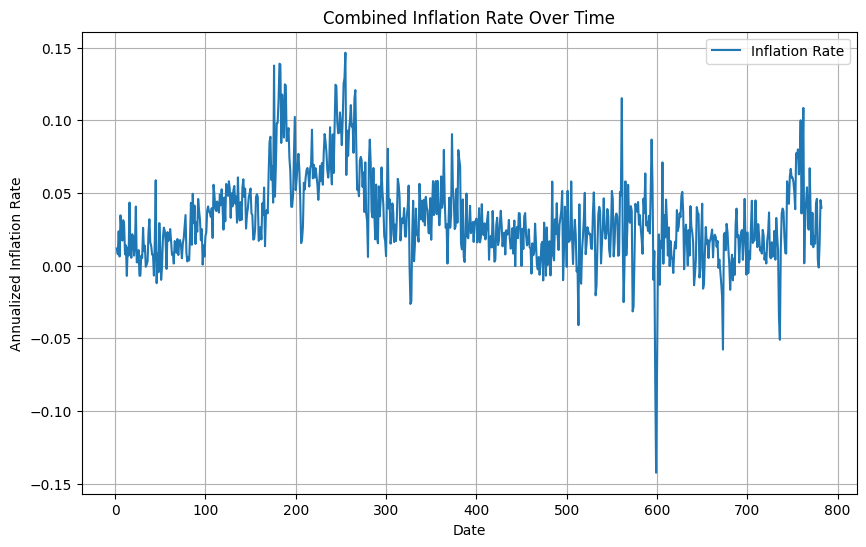

month,New domestic autos,New foreign autos,New light trucks,Net transactions in used autos,Used auto margin,Employee reimbursement,Used light trucks,Tires,Accessories and parts,Furniture,"Clocks, lamps, lighting fixtures, and other household decorative items",Carpets and other floor coverings,Window coverings,Major household appliances,Small electric household appliances,Dishes and flatware,Nonelectric cookware and tableware,"Tools, hardware, and supplies",Outdoor equipment and supplies,Televisions,Other video equipment,Audio equipment,Recording media,Photographic equipment,Information processing equipment,"Sporting equipment, supplies, guns, and ammunition (part of 80)",Motorcycles,Bicycles and accessories,Pleasure boats,Pleasure aircraft,Other recreational vehicles,Recreational books (part of 90),Musical instruments (part of 80),Jewelry,Watches,Therapeutic medical equipment,Corrective eyeglasses and contact lenses,Educational books (96),Luggage and similar personal items (part of 119),Telephone and related communication equipment,Cereals,Bakery products,Beef and veal,Pork,Other meats,Poultry,Fish and seafood,Fresh milk,Processed dairy products,Eggs,Fats and oils,Fruit (fresh),Vegetables (fresh),Processed fruits and vegetables,Sugar and sweets,"Food products, not elsewhere classified","Coffee, tea, and other beverage materials","Mineral waters, soft drinks, and vegetable juices",Spirits,Wine,Beer,Food produced and consumed on farms (6),Women's and girls' clothing (10),Men's and boys' clothing (11),Children's and infants' clothing (12),Clothing materials,Standard clothing issued to military personnel,Shoes and other footwear,Gasoline and other motor fuel,Lubricants and fluids,Fuel oil,Other fuels,Prescription drugs,Nonprescription drugs,Other medical products,"Games, toys, and hobbies",Pets and related products,"Flowers, seeds, and potted plants",Film and photographic supplies,Household cleaning products,Household paper products,Household linens,Sewing items,Miscellaneous household products,"Hair, dental, shaving, and miscellaneous personal care products except electrical products",Cosmetic / perfumes / bath / nail preparations and implements,Electric appliances for personal care,Tobacco (127),Newspapers and periodicals,Stationery and miscellaneous printed materials,Government employees' expenditures abroad,Private employees' expenditures abroad,Less: Personal remittances in kind to nonresidents,Tenant-occupied mobile homes,Tenant-occupied stationary homes and landlord durables,Owner-occupied mobile homes,Owner-occupied stationary homes,Rental value of farm dwellings (22),Group housing (23),Water supply and sewage maintenance,Garbage and trash collection,Electricity (27),Natural gas (28),Physician services (44),Dental services (45),Paramedical services (46),Nonprofit hospitals' services to households,Proprietary hospitals,Government hospitals,Nonprofit nursing homes' services to households,Proprietary and government nursing homes,Motor vehicle maintenance and repair (60),Other motor vehicle services (61),Railway transportation,Intercity buses,Taxicabs and ride sharing services,Intracity mass transit,Other road transportation service,Air transportation (64),Water transportation (65),Membership clubs and participant sports centers,"Amusement parks, campgrounds, and related recreational services",Motion picture theaters,"Live entertainment, excluding sports",Spectator sports,Museums and libraries,"Audio-video, photographic, and information processing equipment services (parts of 77 and 93)",Casino gambling,Lotteries,Pari-mutuel net receipts,Veterinary and other services for pets,Package tours,Maintenance and repair of recreational vehicles and sports equipment,Elementary and secondary school lunches,Higher education school lunches,Other purchased meals,Alcohol in purchased meals,Food supplied to civilians,Food supplied to military,Hotels and motels,Housing at schools,Commercial banks,Other depository institutions and regulated in

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
from IPython.display import display, HTML

# Read training and testing data, using the first column as the row index and the first row as the column names
train_data = pd.read_excel('https://github.com/zhentaoshi/Econ5821/raw/main/data_example/US_PCE_training.xlsx', index_col=0)
test_data = pd.read_excel('https://github.com/zhentaoshi/Econ5821/raw/main/data_example/US_PCE_testing_real.xlsx', index_col=0)

# Extract PCE data
train_pce = train_data.iloc[0, :] 
test_pce = test_data.iloc[0, :] 

# Combine PCE data and calculate the inflation rate
combined_pce = pd.concat([train_pce, test_pce]).astype(float)
combined_inflation_rate = np.log(combined_pce).diff() * 12  
combined_inflation_rate = combined_inflation_rate.dropna()

# Split the training and testing inflation rates
train_inflation_rate = combined_inflation_rate.iloc[:len(train_pce)-1]
test_inflation_rate = combined_inflation_rate.iloc[len(train_pce)-1:]

# Extract feature variables
train_features = train_data.iloc[4:].T 
test_features = test_data.iloc[3:].T

combined_features = pd.concat([train_features, test_features]).astype(float)
combined_predictors = np.log(combined_features).diff() * 12
combined_predictors = combined_predictors.dropna()

train_predictors = combined_predictors.iloc[:len(train_features)-1,:] 
test_predictors = combined_predictors.iloc[len(train_features)-1:,]

# Normalize features
scaler = StandardScaler()
train_predictors_scaled = scaler.fit_transform(train_predictors)
test_predictors_scaled = scaler.transform(test_predictors)
train_predictors_scaled = pd.DataFrame(train_predictors_scaled,index=train_predictors.index,columns=train_predictors.columns)
test_predictors_scaled = pd.DataFrame(test_predictors_scaled,index=test_predictors.index,columns=test_predictors.columns)

# Plot the combined inflation rate
plt.figure(figsize=(10, 6))
plt.plot(combined_inflation_rate.index, combined_inflation_rate.values, label='Inflation Rate')
plt.xlabel('Date')
plt.ylabel('Annualized Inflation Rate')
plt.title('Combined Inflation Rate Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Output the first few rows of combined predictors
display(HTML(combined_predictors.head().to_html(classes='table table-striped table-hover')))

## 2 Model Training

### 2.1 AR(1)

#### 2.1.1 Direct Forecast

In this section, we implement and evaluate the AR(1) models of inflation rates with different forecast horizons: 1-month, 3-month, and 12-month. The AR(1) models are simple autoregressive models where the current value of the series is regressed on its previous value. Here, we take two different forecasting approaches, direct forecast and recursive forecast. For direct forecast, we create seperate models for each forecast horizon. This means for predicting $\hat{y}_{t+h} \mid y_t$, a distinct model is trained specifically for $h$, and each model directly predicts the value without depending on intermediate forecasted values. The plots and MSE (Mean Squared Error) values below provide a visual and quantitative assessment of the models' fit to the training data.

In-sample MSE for 1-Month Model: 0.00043457980266529587
In-sample MSE for 3-Month Model: 0.0006144393178415042
In-sample MSE for 12-Month Model: 0.0006887413346311211


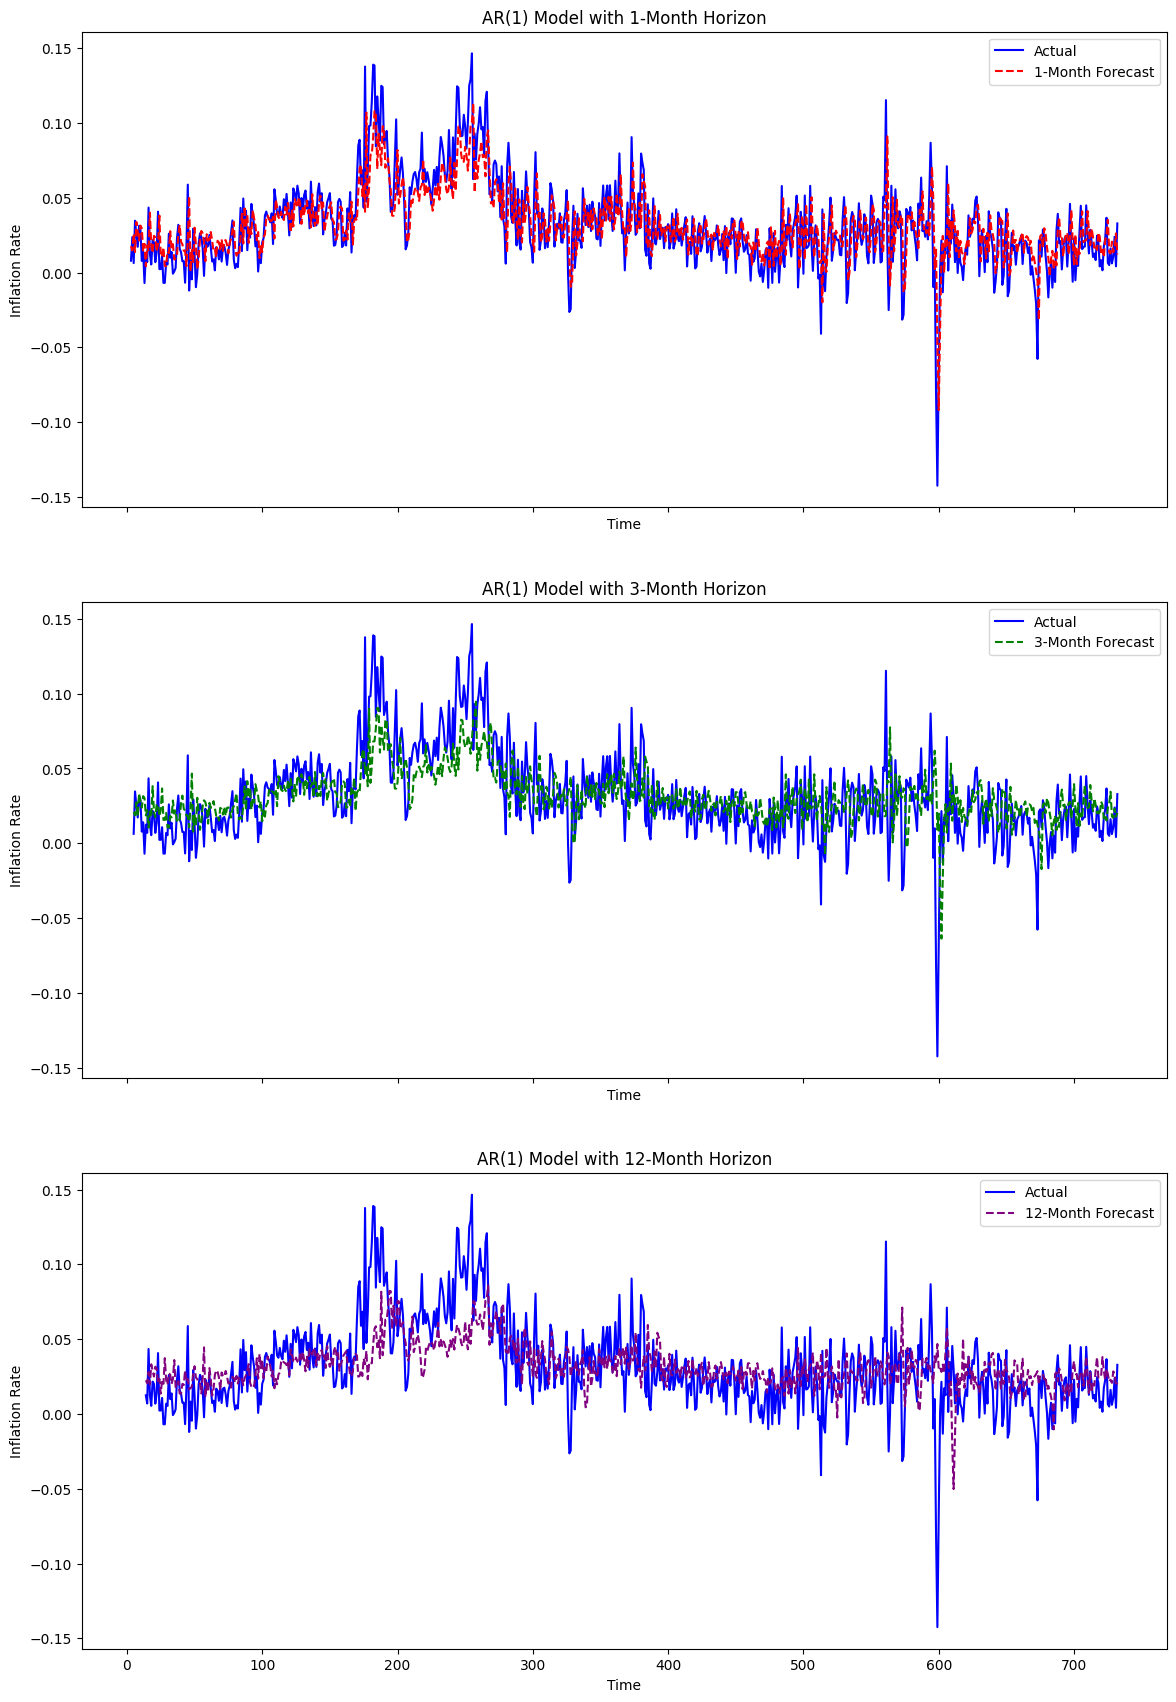

In [15]:
import statsmodels.api as sm

# Fit AR1 models with different horizons
def fit_ar1_model(data, horizons):
    y = data[horizons:]
    X = data.shift(horizons)[horizons:]
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    results = model.fit()
    
    return results

ar1_model_1m = fit_ar1_model(train_inflation_rate, 1)
ar1_model_3m = fit_ar1_model(train_inflation_rate, 3)
ar1_model_12m = fit_ar1_model(train_inflation_rate, 12)

# Visualizing In-Sample Fit
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 21), sharex=True)
for ax, model, horizon, color in zip(axes, [ar1_model_1m, ar1_model_3m, ar1_model_12m], [1, 3, 12], ['red', 'green', 'purple']):
    predictions = model.predict(sm.add_constant(train_inflation_rate.shift(horizon)[horizon:]))
    ax.plot(train_inflation_rate.index[horizon:], train_inflation_rate[horizon:], label='Actual', color='blue')
    ax.plot(train_inflation_rate.index[horizon:], predictions, label=f'{horizon}-Month Forecast', linestyle='--', color=color)
    ax.set_title(f'AR(1) Model with {horizon}-Month Horizon')
    ax.set_xlabel('Time')
    ax.set_ylabel('Inflation Rate')
    ax.legend()
    print(f'In-sample MSE for {horizon}-Month Model:', mean_squared_error(train_inflation_rate[horizon:], predictions))

plt.show()

We then use the previously fitted AR(1) models to predict the inflation rate for the testing period and compare these predictions with the actual values. As is shown in the plot below, for the 1-month-ahead forcast, the predictions closely follow the actual values, capturing the general trend and fluctuations, while the 3-month forecast shows a slight lag compared to the actuals, and the 12-month forecast diverge more significantly. The increasing MSE values also demonstrates the increased uncertainty and error associated with longer forecast horizons, which is expected due to the nature of time series forecasting.

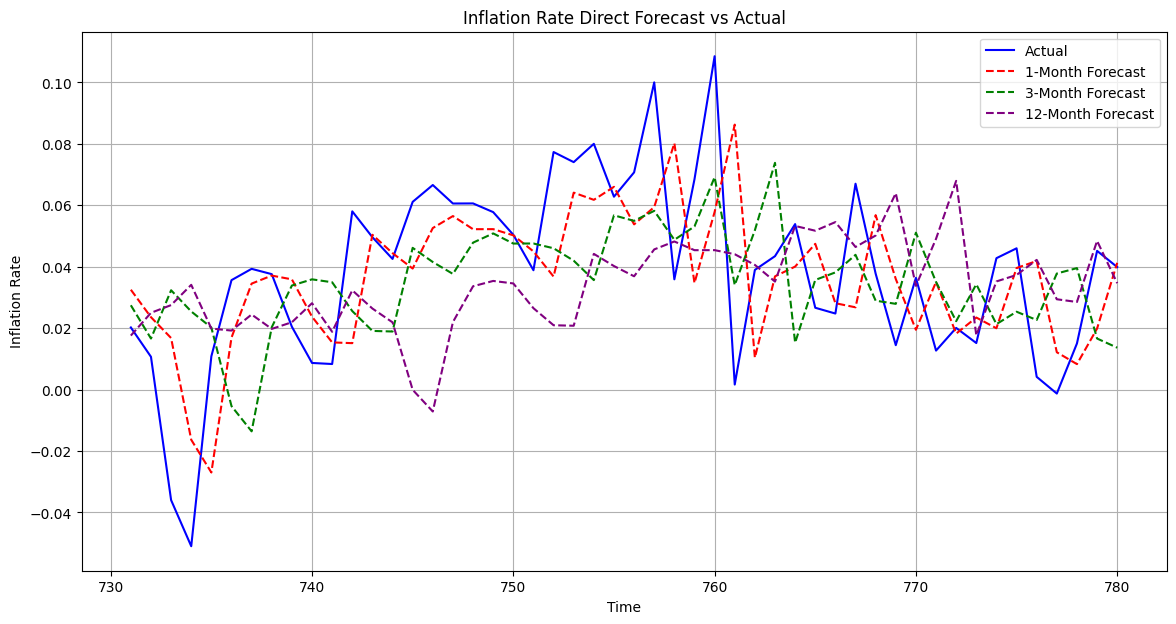

Out-of-sample MSE for 1-Month Model: 0.0006760889859332823
Out-of-sample MSE for 3-Month Model: 0.0007983241623618524
Out-of-sample MSE for 12-Month Model: 0.0011235454205496566


In [16]:
# Predicting and plotting out-of-sample forecasts
start_index = len(train_inflation_rate)  
end_index = start_index + len(test_inflation_rate)  

predictions_1m = []
predictions_3m = []
predictions_12m = []

for i in range(start_index, end_index):
        pred_1m = ar1_model_1m.predict([1, combined_inflation_rate[i + 2 -1]])[0]
        predictions_1m.append(pred_1m)

        pred_3m = ar1_model_3m.predict([1, combined_inflation_rate[i + 2 -3]])[0]
        predictions_3m.append(pred_3m)


        pred_12m = ar1_model_12m.predict([1, combined_inflation_rate[i + 2 -12]])[0]
        predictions_12m.append(pred_12m)

plt.figure(figsize=(14, 7))
actuals = combined_inflation_rate[start_index:end_index]
plt.plot(range(start_index, end_index), actuals, label='Actual', color='blue')
plt.plot(range(start_index, end_index), predictions_1m, label='1-Month Forecast', color='red', linestyle='--')
plt.plot(range(start_index, end_index), predictions_3m, label='3-Month Forecast', color='green', linestyle='--')
plt.plot(range(start_index, end_index), predictions_12m, label='12-Month Forecast', color='purple', linestyle='--')
plt.title('Inflation Rate Direct Forecast vs Actual')
plt.xlabel('Time')
plt.ylabel('Inflation Rate')
plt.legend()
plt.grid(True)
plt.show()

# Calculate and store out-of-sample MSE
mse_ar1_direct = {
    1: mean_squared_error(actuals, predictions_1m),
    3: mean_squared_error(actuals, predictions_3m),
    12: mean_squared_error(actuals, predictions_12m)
}

# Print out-of-sample MSE
print('Out-of-sample MSE for 1-Month Model:', mse_ar1_direct[1])
print('Out-of-sample MSE for 3-Month Model:', mse_ar1_direct[3])
print('Out-of-sample MSE for 12-Month Model:', mse_ar1_direct[12])

#### 2.1.2 Recursive Forecast

Recursive forecast involves using a single one-step AR(1) model to make multi-step forecasts. Specifically, we use the model to predict the next value, and the predicted value is then used as an input for the subsequent prediction, iterating through the desired forecast horizon. This approach could potentitally reduce computational complexity and training time but may suffer from error accumulation over longer horizons.

The plot below illustrates the out-of-sample comparison between the actual inflation rates and the recursive forecasts. For the 12-month-ahead forecast, the predictions are almost flat, failing to capture the variability in the actual data. This is because if we specify the one-step AR(1) model as $y_t=\mu+\phi y_{t-1}+\epsilon_t$, the h-step-ahead forecast is simply $\mathbb{E}_t[y_{t+h}|y_t]=(1+\phi+\phi^2+...+\phi^{h-1})\mu+\phi^h y_t$, which would converge to $\mu / (1-\phi)$ when $h$ becomes large. When $h$ takes the value of 12, the fluctuation of inflation rate is compressed to nearly zero by $\phi^{12}$.

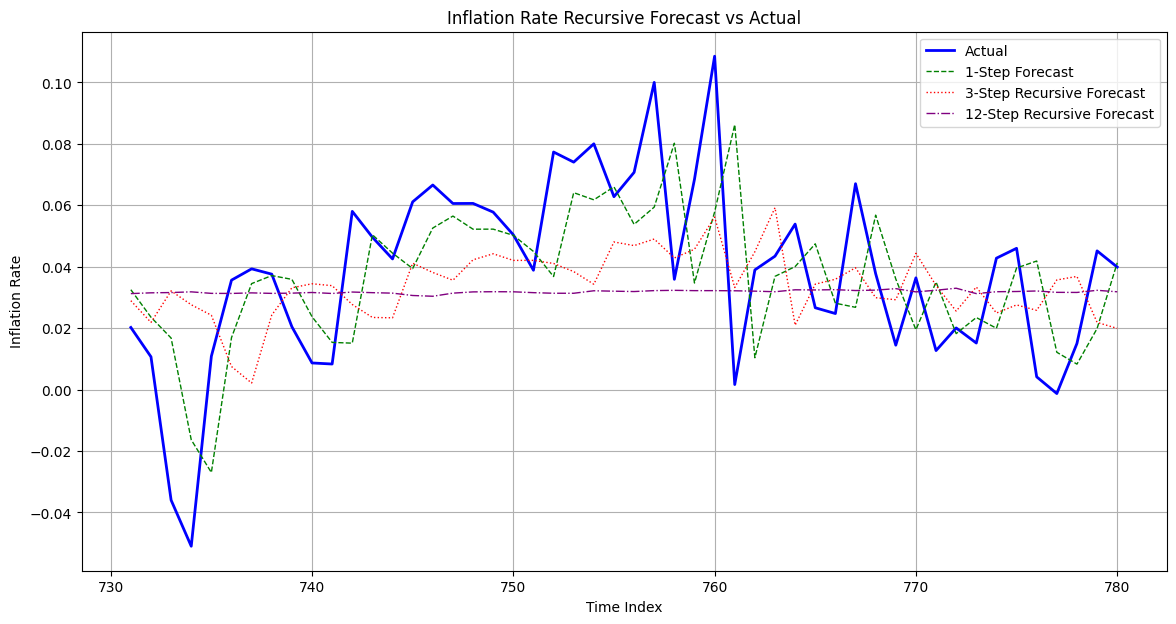

Out-of-sample MSE for 1-step: 0.0006760889859332823
Out-of-sample MSE for 3-step: 0.0007834562980553277
Out-of-sample MSE for 12-step: 0.000940389965762182


In [17]:
ar1_model = ar1_model_1m

def recursive_forecast(model, start_value, steps):
    current_value = start_value
    for _ in range(steps):
        next_value = model.predict([1, current_value])[0]
        current_value = next_value
    return current_value

start_index = len(train_inflation_rate) 
end_index = start_index + len(test_inflation_rate) 

one_step_results = []
three_step_results = []
twelve_step_results = []

for t in range(start_index, end_index):
    one_step_forecast = recursive_forecast(ar1_model, combined_inflation_rate[t + 2 - 1], 1)
    one_step_results.append(one_step_forecast)
    
    three_step_forecast = recursive_forecast(ar1_model, combined_inflation_rate[t + 2 - 3], 3)
    three_step_results.append(three_step_forecast)

    twelve_step_forecast = recursive_forecast(ar1_model, combined_inflation_rate[t +2 - 12], 12)
    twelve_step_results.append(twelve_step_forecast)

plt.figure(figsize=(14, 7))
plt.plot(range(start_index, end_index), combined_inflation_rate[start_index:end_index], label='Actual', color='blue', linewidth=2)
plt.plot(range(start_index, end_index), one_step_results, label='1-Step Forecast', color='green', linestyle='--', linewidth=1)
plt.plot(range(start_index, end_index), three_step_results, label='3-Step Recursive Forecast', color='red', linestyle=':', linewidth=1)
plt.plot(range(start_index, end_index), twelve_step_results, label='12-Step Recursive Forecast', color='purple', linestyle='-.', linewidth=1)
plt.title('Inflation Rate Recursive Forecast vs Actual')
plt.xlabel('Time Index')
plt.ylabel('Inflation Rate')
plt.legend()
plt.grid(True)
plt.show()

# Calculating and displaying Out-of-sample MSE
mse_ar1_recursive = {
    1: mean_squared_error(test_inflation_rate, one_step_results),
    3: mean_squared_error(test_inflation_rate, three_step_results),
    12: mean_squared_error(test_inflation_rate, twelve_step_results)
}
print('Out-of-sample MSE for 1-step:', mse_ar1_recursive[1])
print('Out-of-sample MSE for 3-step:', mse_ar1_recursive[3])
print('Out-of-sample MSE for 12-step:', mse_ar1_recursive[12])

### 2.2 LASSO

#### 2.2.1 Model Training and In-Sample Fitting

LASSO (Least Absolute Shrinkage and Selection Operator) is a type of linear regression that includes an L1 penalty, which can shrink some coeffiecients to zero. Thus it is particularly useful when dealing with high-dimensional data by effectively selecting relevant predictors.

First, we prepare the datasets by creating lagged versions of the inflation rate and other predictors. Then we train LASSO models seperately for the required horizons, where we perform cross validation to select the optimal regularization parameter ($\alpha$). Traiditional cross validation techniques, like k-fold, are unsuitable for time-series data as they neglect the temporal structure of the data. Therefore, we use time-series cross validation (TSCV) and take a rolling window apprach instead, where the training subset is incrementally increased, and the model is validated on subsequent data points. The trained models' in-sample fit is shown as follows.

Selected optimal alpha value: 0.000720


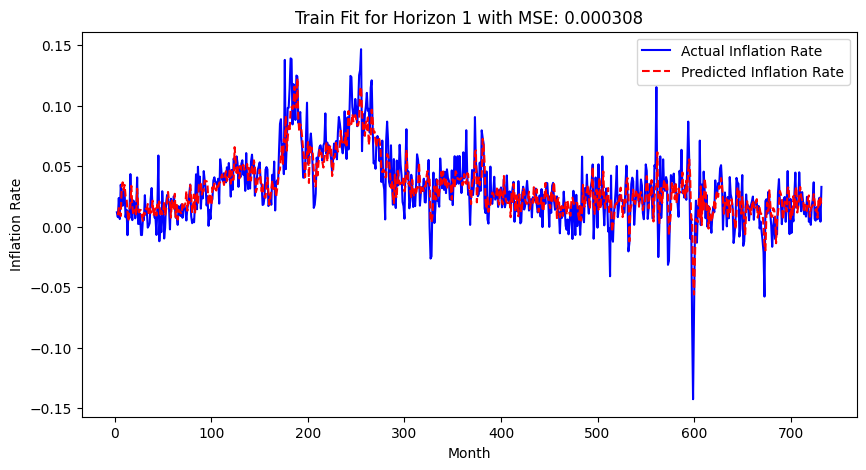

Selected optimal alpha value: 0.000848


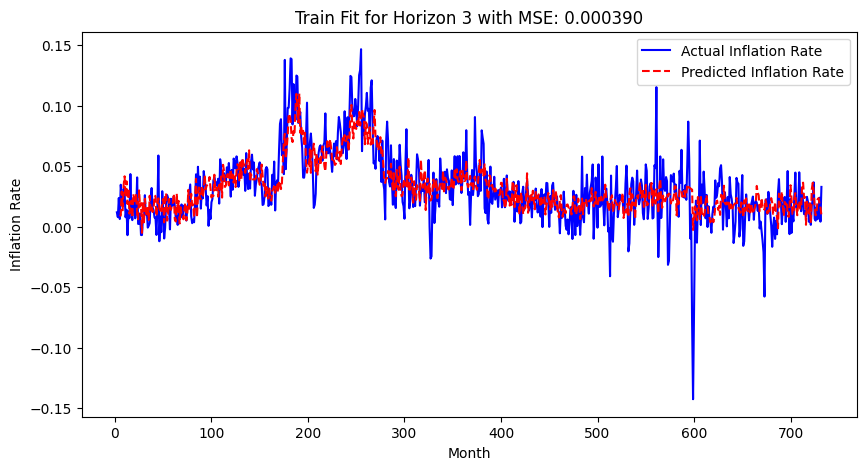

Selected optimal alpha value: 0.001638


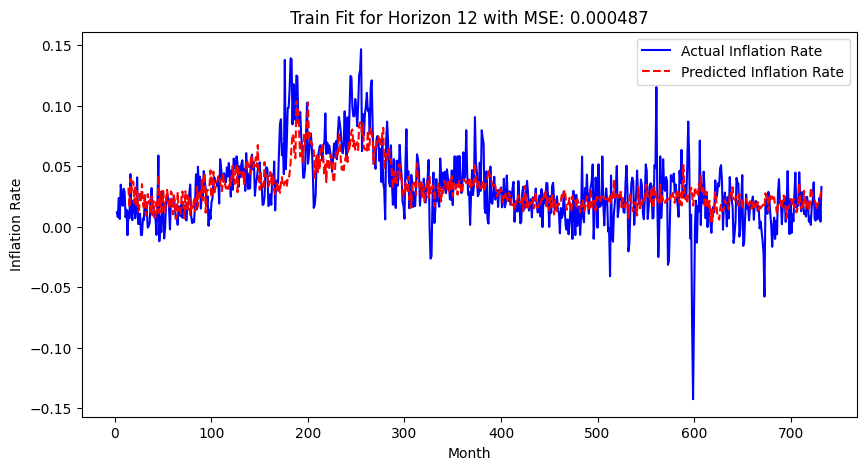

In [18]:
from sklearn.linear_model import LassoCV

def prepare_data_for_LASSO(horizon, train_inflation, predictors):
    # Create datasets of lagged inflation rates and other predictors
    X_inflation_lag = train_inflation.shift(horizon).dropna()  # Lagged inflation rate
    X_predictors_lag = predictors.shift(horizon).dropna()  # Lagged other predictors
    y = train_inflation.iloc[horizon:]  # Current inflation rate

    # Combine lagged inflation rates and other predictors
    X = pd.concat([X_inflation_lag, X_predictors_lag], axis=1).iloc[:len(y), :]
    return X, y

alphas = np.logspace(-4, -0.5, 50) # Define a range of alphas

def train_lasso_model(X, y, n_splits):
    # Use TimeSeriesSplit for time-series cross-validation
    tscv = TimeSeriesSplit(n_splits=n_splits)
    lasso_model = LassoCV(alphas=alphas, cv=tscv, random_state=0, max_iter=10000).fit(X, y)
    return lasso_model

def plot_predictions(train_inflation_rate, y_pred, horizon, title):
    plt.figure(figsize=(10, 5))
    y_pred_full = pd.Series([np.nan] * len(train_inflation_rate), index=train_inflation_rate.index)
    y_pred_full.iloc[horizon:] = y_pred
    
    plt.plot(train_inflation_rate, label='Actual Inflation Rate', color='blue')
    plt.plot(y_pred_full, label='Predicted Inflation Rate', linestyle='--', color='red')
    plt.title(title)
    plt.xlabel('Month')
    plt.ylabel('Inflation Rate')
    plt.legend()
    plt.show()

horizons = [1, 3, 12]
models_lasso = {}
n_splits = 5

for horizon in horizons:
    X_lag, y_lag = prepare_data_for_LASSO(horizon, train_inflation_rate, train_predictors_scaled)
    model_lasso = train_lasso_model(X_lag, y_lag, n_splits)
    models_lasso[horizon] = model_lasso
    print(f"Selected optimal alpha value: {model_lasso.alpha_:.6f}")
    # Prediction
    y_pred = model_lasso.predict(X_lag)
    
    train_mse = mean_squared_error(y_lag, y_pred)
    
    # Plot
    plot_predictions(train_inflation_rate, y_pred, horizon, f'Train Fit for Horizon {horizon} with MSE: {train_mse:.6f}')

#### 2.2.2 Out-of-Sample Prediction

The code below outlines the steps for evaluating the out-of-sample performance of the LASSO models trained in the previous section. Similarly, the 1-month-ahead model shows a close fit to the actual data, while the models with longer horizons capture some of the broader trends but show less precision.

1-month-ahead model out-of-sample MSE: 0.0006361725041335094


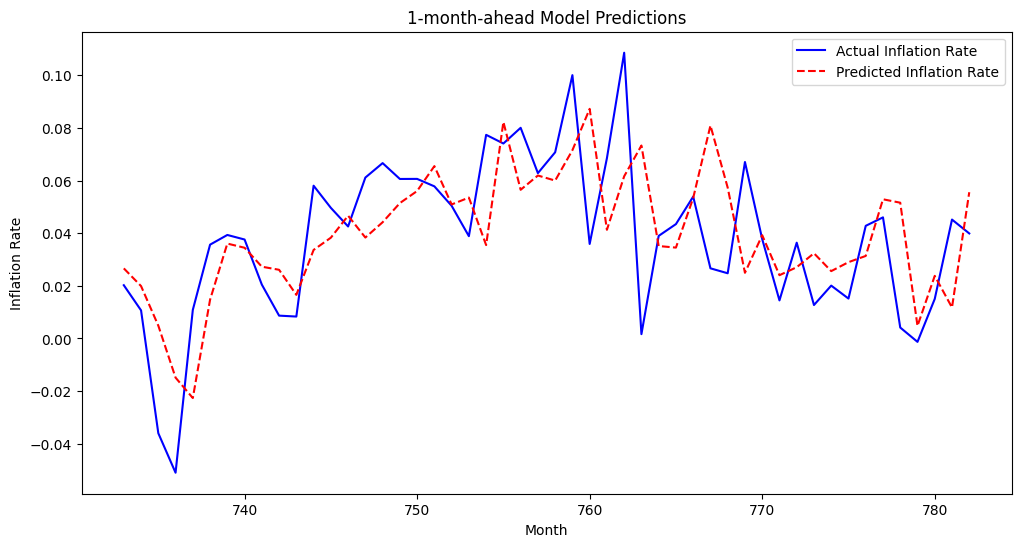

3-month-ahead model out-of-sample MSE: 0.0009474639587794424


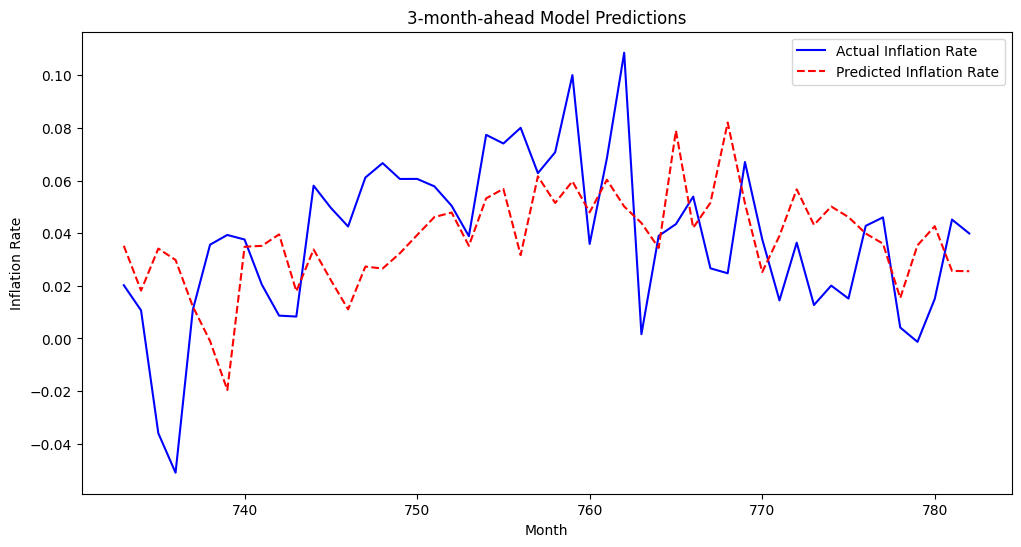

12-month-ahead model out-of-sample MSE: 0.001026751560253959


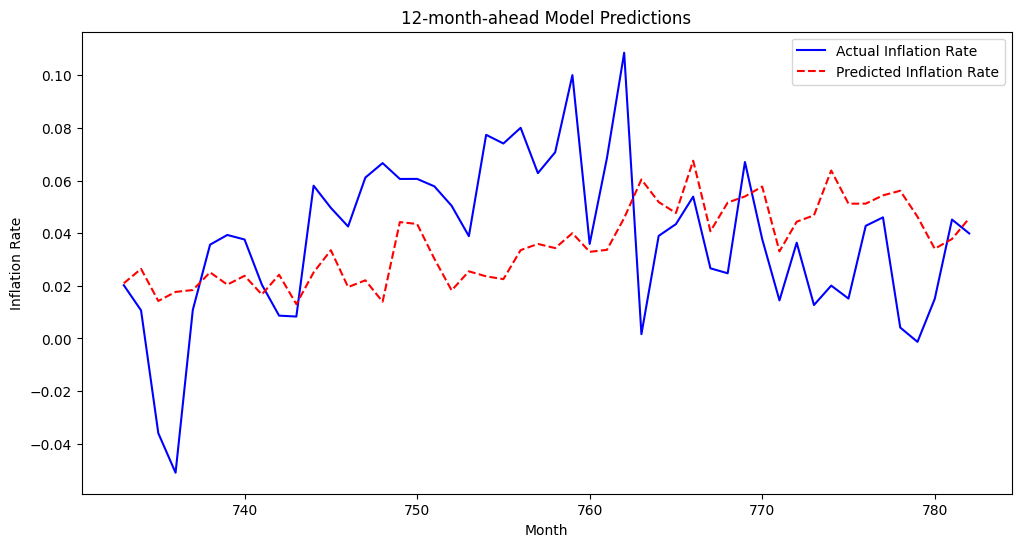

In [19]:
def plot_test_predictions(y_true, y_pred, title):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='Actual Inflation Rate', color='blue')
    plt.plot(y_true.index, y_pred, label='Predicted Inflation Rate', linestyle='--', color='red')
    plt.title(title)
    plt.xlabel('Month')
    plt.ylabel('Inflation Rate')
    plt.legend()
    plt.show()

# Store each model's prediction results
test_predictions = {}
mse_lasso = {}

for horizon, model_lasso in models_lasso.items():
    # Extract the tail part of the training data to fulfill the lag requirement
    train_inflation_tail = train_inflation_rate[-horizon:]
    train_predictors_tail = train_predictors_scaled.tail(horizon)
    
    # Concatenate training tail and test data to create a full test dataset
    test_inflation_rate_full = pd.concat([train_inflation_tail, test_inflation_rate])
    test_predictors_full = pd.concat([train_predictors_tail, pd.DataFrame(test_predictors_scaled, index=test_predictors.index)])

    # Prepare data
    X_test, y_test_actual = prepare_data_for_LASSO(horizon, test_inflation_rate_full, test_predictors_full)
    
    # Perform predictions
    model_lasso = models_lasso[horizon]
    y_pred = model_lasso.predict(X_test)
    test_predictions[horizon] = y_pred
    
    # Calculate MSE
    mse = mean_squared_error(y_test_actual, y_pred)
    mse_lasso[horizon] = mse
    print(f"{horizon}-month-ahead model out-of-sample MSE: {mse}")
    
    plot_test_predictions(test_inflation_rate, y_pred, f"{horizon}-month-ahead Model Predictions")

Aditionally, we explored the Adaptive LASSO approach, which incorporates adaptive weights based on the Ordinary Least Squares (OLS) coefficients. This method modifies the standard LASSO by assigning different penalties to different coefficients, based on their importance inferred from an initial OLS fit. Despite the theoretical benefits of this approach, the resulting models showed poor prediction performance in our experiments due to the potential of overfitting and weight sensitivity, and consequently is not included in the main report. However, the implementation details can be found in our repository, specifically in the "LASSO.ipynb" notebook. 

### 2.3 SVR

#### 2.3.1 Model Training and In-Sample Fitting

Support Vector Regression (SVR) is a type of Support Vector Machine (SVM) that aims to find a function deviating from the actual target values by a value no greater than $\epsilon$. SVR uses the kernel trick to transform data into a higher-dimensional space. In our implementation, we use the RBF (radial basis function) kernel, which is effective for non-linear relationships. For hyperparameters, we perform TSCV and grid search to select the optimal $C$s, $\epsilon$s and $\gamma$s. The SVR models are trained for the required forcast horizons. The optimal parameters and in-sample fit are shown as follows.

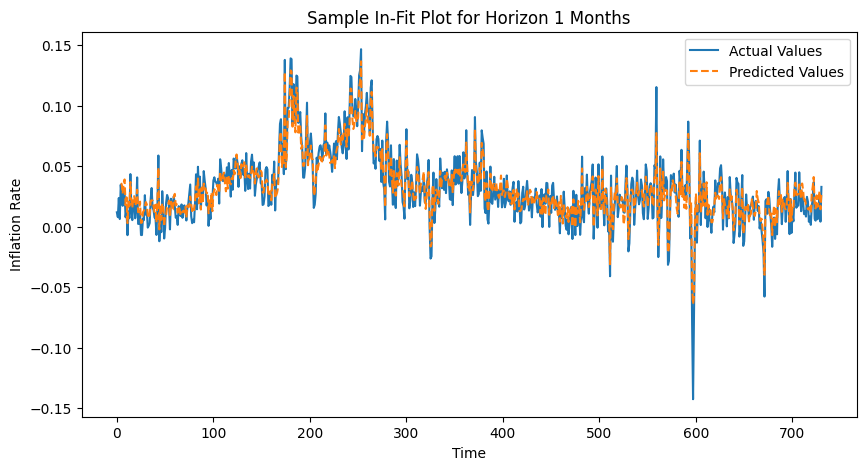

Horizon 1 months: Best Parameters: {'C': 0.1, 'epsilon': 0.01, 'gamma': 'auto'}
Horizon 1 months: MSE = 0.000084


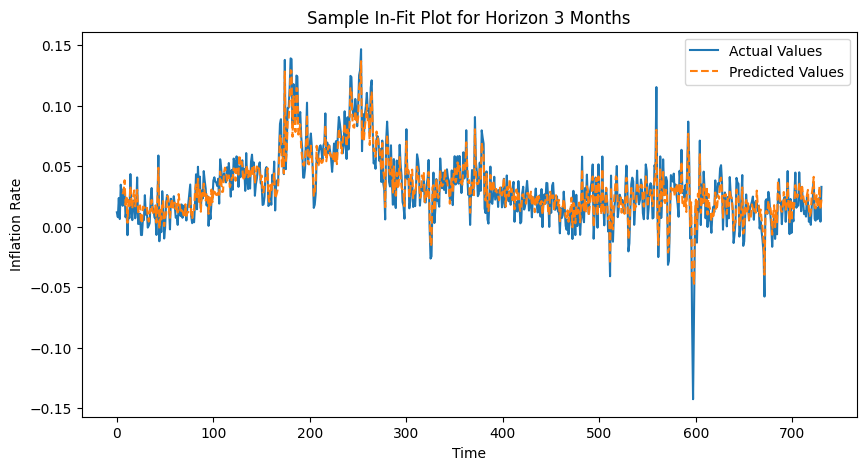

Horizon 3 months: Best Parameters: {'C': 0.1, 'epsilon': 0.01, 'gamma': 'auto'}
Horizon 3 months: MSE = 0.000093


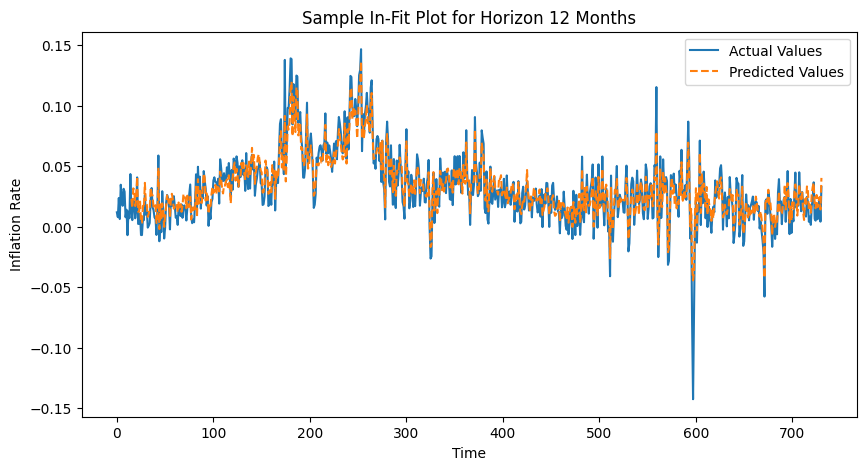

Horizon 12 months: Best Parameters: {'C': 0.1, 'epsilon': 0.01, 'gamma': 'auto'}
Horizon 12 months: MSE = 0.000100


In [20]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

train_predictors_scaled_np = np.array(train_predictors_scaled)
test_predictors_scaled_np = np.array(test_predictors_scaled)

def prepare_data_for_svr(features, target, n_lags, horizon):
    X, y = [], []
    # Loop over the indices of the target array that allow for both lags and horizon
    for i in range(n_lags + horizon, len(target)):
        start_idx = i - horizon - n_lags
        end_idx = i - horizon
       
        feature_set = features[start_idx:end_idx].flatten()  # Lagged predictor features
        target_lags = target[start_idx:end_idx].flatten()  # Lagged values of the target variable
        X.append(np.hstack([feature_set, target_lags]))
        y.append(target[i])
    return np.array(X), np.array(y)

# Model training and evaluation for different horizons
horizons = [1, 3, 12]
n_lags = 3
models_svr = {}
mse_scores = {}

for horizon in horizons:
    X_train, y_train = prepare_data_for_svr(train_predictors_scaled_np, train_inflation_rate.values, n_lags, horizon)
    param_grid = {
        'C': [0.1, 1, 10],
        'epsilon': [0.01, 0.1, 0.5],
        'gamma': ['auto', 'scale', 0.01, 0.1]
    }
    tscv = TimeSeriesSplit(n_splits=5)
    grid_search = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=tscv, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    models_svr[horizon] = best_model
    y_pred = best_model.predict(X_train)
    mse = mean_squared_error(y_train, y_pred)
    mse_scores[horizon] = mse

    # Plotting actual vs predicted values
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(train_inflation_rate)), train_inflation_rate, label='Actual Values')
    pred_start = n_lags + horizon
    plt.plot(range(pred_start, pred_start + len(y_pred)), y_pred, label='Predicted Values', linestyle='--')
    plt.title(f'Sample In-Fit Plot for Horizon {horizon} Months')
    plt.xlabel('Time')
    plt.ylabel('Inflation Rate')
    plt.legend()
    plt.show()

    print(f"Horizon {horizon} months: Best Parameters: {grid_search.best_params_}")
    print(f"Horizon {horizon} months: MSE = {mse:.6f}")

#### 2.3.2 Out-of-Sample Prediction

The SVR models trained in the previous section are used to forecast the inflation period, and the results are visualized below. The plots reveal that the predicted inflation rates for all three horizons appear quite flat compared to the actual values. This flattening effect could be attributed to the selected parameters. For example, the $C$ parameter controls the trade-off between achieving a low error on the training data and minimizing the model complexity. A low $C$ value (0.1) implies that the model is less sensitive to individual data points and aims for a smoother decision boudary. The $\epsilon$ parameter defines a margin within which errors are not penalized. A small $\epsilon$ value (0.01) creates a tight fit but may make the model less responsive to changes in the data outside this margin, resulting in smoother and flatter predictions.

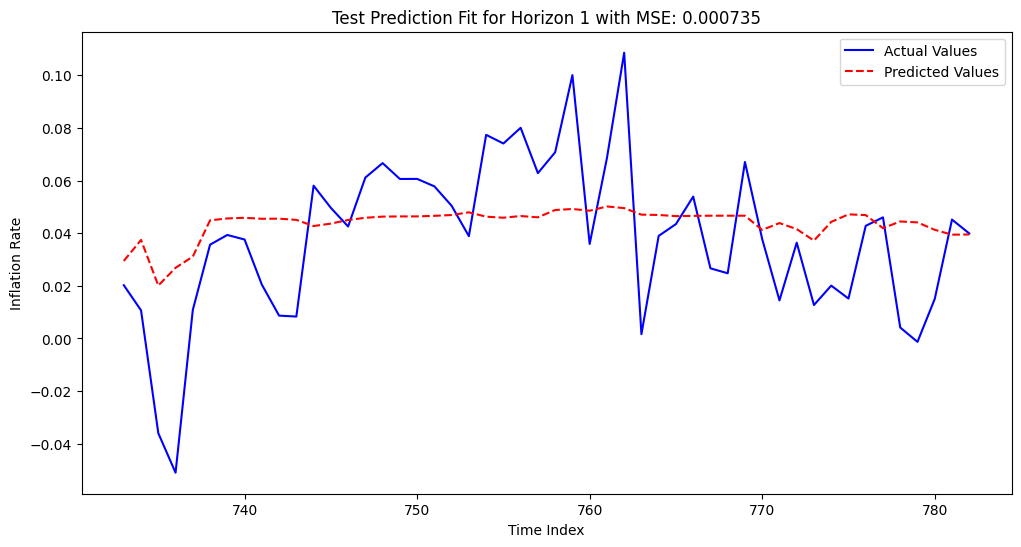

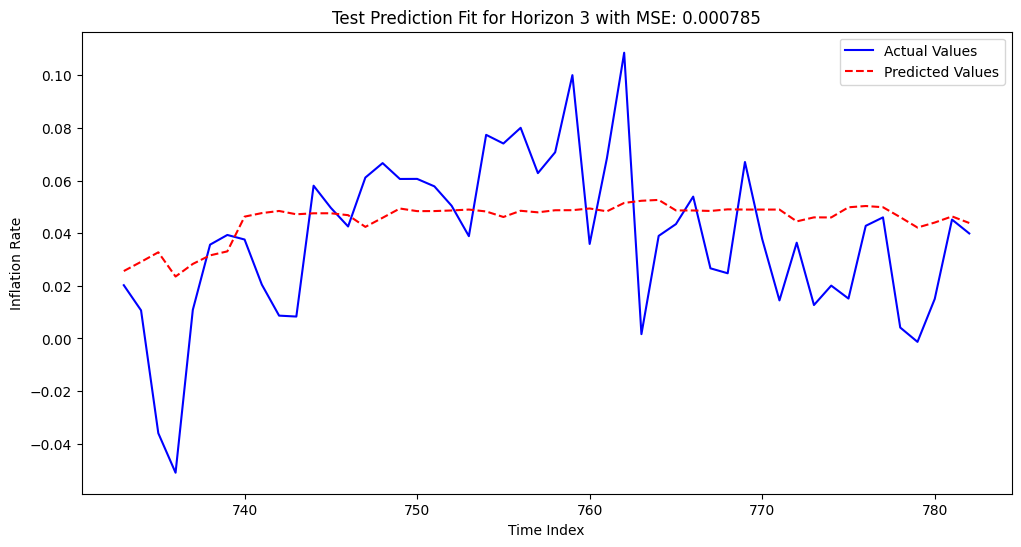

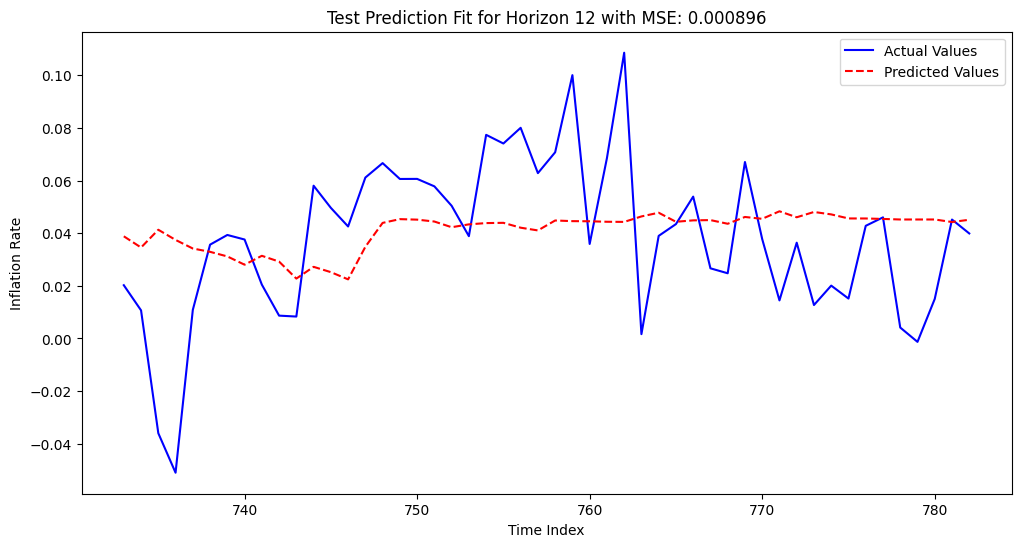

In [21]:
def prepare_test_data(train_features, train_target, test_features, test_target, n_lags, horizon):
    # Extend test features by including sufficient training set tail data to handle lag and horizon
    combined_features = np.vstack([train_features[-(n_lags + horizon):], test_features])
    combined_target = np.concatenate([train_target[-(n_lags + horizon):], test_target])
    
    X_test, y_test = [], []
    # Start index is after the initial n_lags + horizon to form a complete first set of features
    start_index = n_lags + horizon

    # Iterate through combined data to form feature and target sets for testing
    for i in range(start_index, len(combined_target)):
        start_idx = i - n_lags - horizon
        end_idx = i - horizon
        # Flatten feature sets to create a single array per sample
        feature_set = combined_features[start_idx:end_idx].flatten()
        target_lags = combined_target[start_idx:end_idx].flatten()
        
        X_test.append(np.hstack([feature_set, target_lags]))
        y_test.append(combined_target[i])

    return np.array(X_test), np.array(y_test)

mse_svr = {}
for horizon in horizons:
    X_test, y_test = prepare_test_data(train_predictors_scaled_np, train_inflation_rate, test_predictors_scaled, test_inflation_rate, n_lags, horizon)
    model_svr = models_svr[horizon]  # Retrieve the model trained for this specific horizon
    
    y_pred_test = model_svr.predict(X_test)
    mse_svr[horizon] = mean_squared_error(y_test, y_pred_test)

    end_idx = len(combined_inflation_rate)  
    start_idx = end_idx - 50  

    plt.figure(figsize=(12, 6))
    plt.plot(combined_inflation_rate.index[start_idx:end_idx], y_test, label='Actual Values', color='blue')
    plt.plot(combined_inflation_rate.index[start_idx:end_idx], y_pred_test, label='Predicted Values', linestyle='--', color='red')
    plt.title(f"Test Prediction Fit for Horizon {horizon} with MSE: {mse_svr[horizon]:.6f}")
    plt.xlabel('Time Index')
    plt.ylabel('Inflation Rate')
    plt.legend()
    plt.show()

### 2.4 Random Forest

#### 2.4.1 Model Training and In-Sample Fitting

In our repository, we have included a file "Decision Tree.ipynb" taking a decision tree approach. Random Forest is an ensemble learning method that constructs multiple decision trees during training and outputs the mean prediction of the individual trees for regression tasks, thus improving predictive performance and robustness by averaging out the biases. Similarly, we use TSCV to select the optimal hyperparameters. The parameter n_estimators defines the number of trees in the forest. The optimal numbers of 100 suggest a balance between model complexity and computational efficiency. The parameter max_depth of 10 indicates that the trees are restricted to a moderate level of complexity to prevent overfitting. In addition to the standard Random Forest approach, we also explored using a block bootstrap method and performed manual grid search, which can be found in "Random Forest.ipynb".

Horizon 1: Best CV MSE 0.0007638457073226545, Best Params {'max_depth': 10, 'n_estimators': 100}


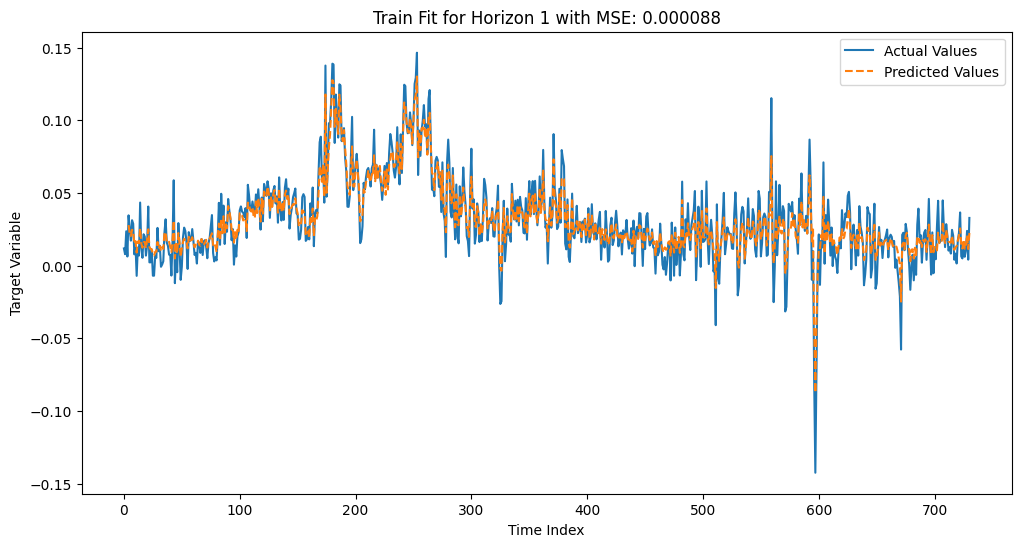

Horizon 3: Best CV MSE 0.0007663975987406811, Best Params {'max_depth': 10, 'n_estimators': 100}


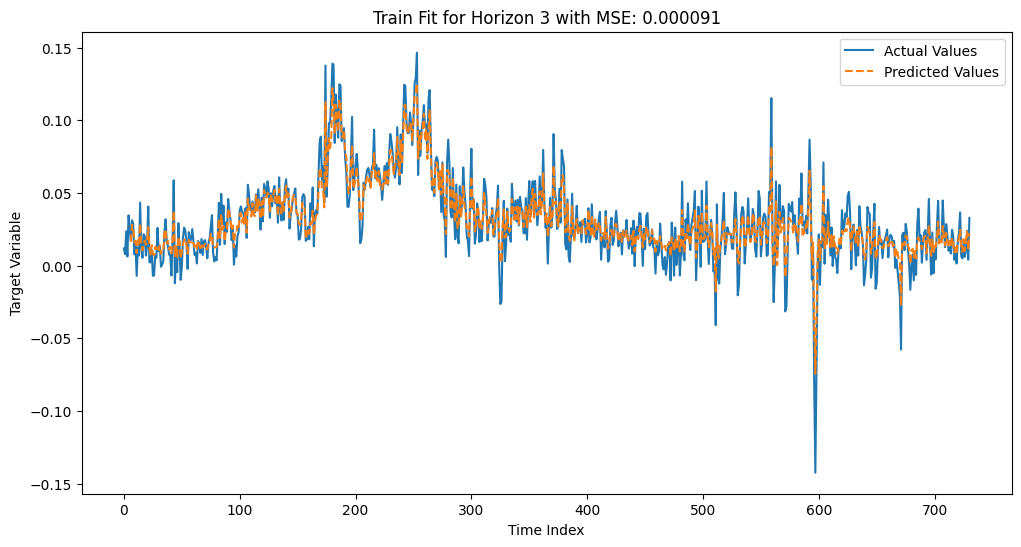

Horizon 12: Best CV MSE 0.0009153265259572076, Best Params {'max_depth': 10, 'n_estimators': 150}


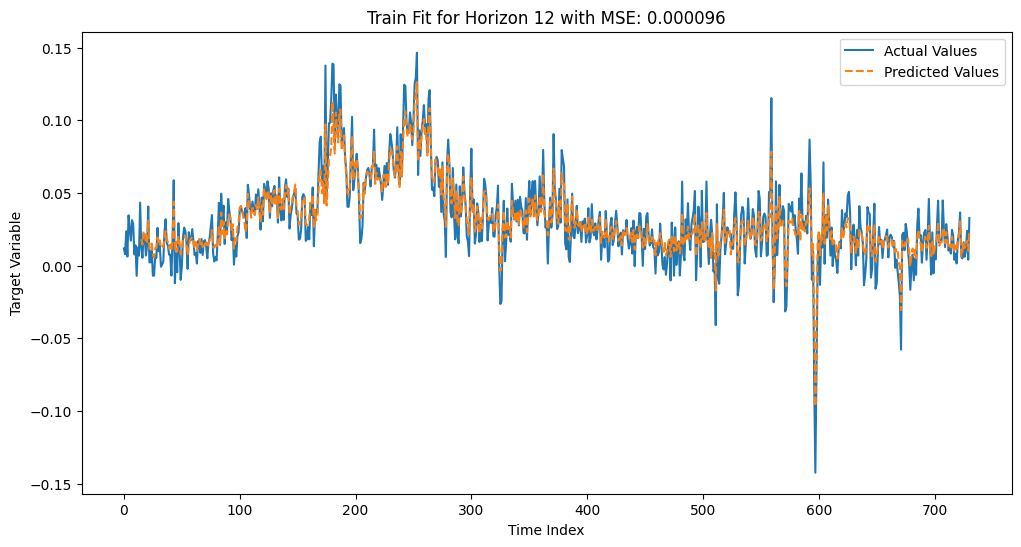

In [6]:
from sklearn.ensemble import RandomForestRegressor

def prepare_data(features, target, n_lags, horizon):
    X, y = [], []
    # Loop over the indices of the target array that allow for both lags and horizon
    for i in range(n_lags + horizon, len(target)):
        start_idx = i - horizon - n_lags
        end_idx = i - horizon
        feature_set = features.iloc[start_idx:end_idx].to_numpy().flatten()  # Lagged predictor features
        target_lags = target.iloc[start_idx:end_idx].to_numpy().flatten()  # Lagged values of the target variable  
        X.append(np.hstack([feature_set, target_lags]))
        # Append the actual target value for the corresponding time point 'i' to the target list
        y.append(target.iloc[i])
    return np.array(X), np.array(y)
    
def perform_random_forest(X, y, n_splits, param_grid):
    # Initialize the Time Series Cross-Validator
    tscv = TimeSeriesSplit(n_splits=n_splits)
    best_score = float('inf')
    best_params = {}

    # Iterate over all possible combinations of parameters in the parameter grid
    for params in ParameterGrid(param_grid):
        model_random_forest = RandomForestRegressor(**params, random_state=42, n_jobs=-1)
        scores = []

        for train_idx, test_idx in tscv.split(X):
            X_train, y_train = X[train_idx], y[train_idx]
            X_test, y_test = X[test_idx], y[test_idx]
            model_random_forest.fit(X_train, y_train)
            y_pred = model_random_forest.predict(X_test)
            score = mean_squared_error(y_test, y_pred)
            scores.append(score)

        avg_score = np.mean(scores)
        if avg_score < best_score:
            best_score = avg_score
            best_params = params

    # Re-fit the model with the best parameters found on the entire dataset
    model_random_forest.set_params(**best_params)
    model_random_forest.fit(X, y)
    return model_random_forest, best_score, best_params

n_lags = 3
horizons = [1, 3, 12]

# Set the parameter grid for tuning the RandomForest model
param_grid = {
    'n_estimators': [50, 100, 150],  # Number of trees in the forest
    'max_depth': [10, 20, 30]  # Maximum depth of each tree
}
n_splits = 5

models_random_forest = {}
for horizon in horizons:
    X, y = prepare_data(train_predictors, train_inflation_rate, n_lags, horizon)
    model_random_forest, best_score, best_params = perform_random_forest(X, y, n_splits, param_grid)
    models_random_forest[horizon] = model_random_forest
    print(f"Horizon {horizon}: Best CV MSE {best_score}, Best Params {best_params}")

    # Predict on the training dataset to evaluate fit
    y_pred = model_random_forest.predict(X)

    # Calculate Mean Squared Error on the training dataset
    train_mse = mean_squared_error(y, y_pred)

    # Prepare a plot to visualize actual values and predictions
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(train_inflation_rate)), train_inflation_rate, label='Actual Values')
    # Plot predictions with an offset
    pred_start = n_lags + horizon
    plt.plot(range(pred_start, pred_start + len(y_pred)), y_pred, label='Predicted Values', linestyle='--')
    plt.title(f'Train Fit for Horizon {horizon} with MSE: {train_mse:.6f}')
    plt.xlabel('Time Index')
    plt.ylabel('Target Variable')
    plt.legend()
    plt.show()

#### 2.4.2 Out-of-Sample Prediction

In this subsection, we evaluate the out-of-sample performance of the Random Forest models trained for the required horizons. The visualized results and the out-of-sample MSE calculated are shown below.

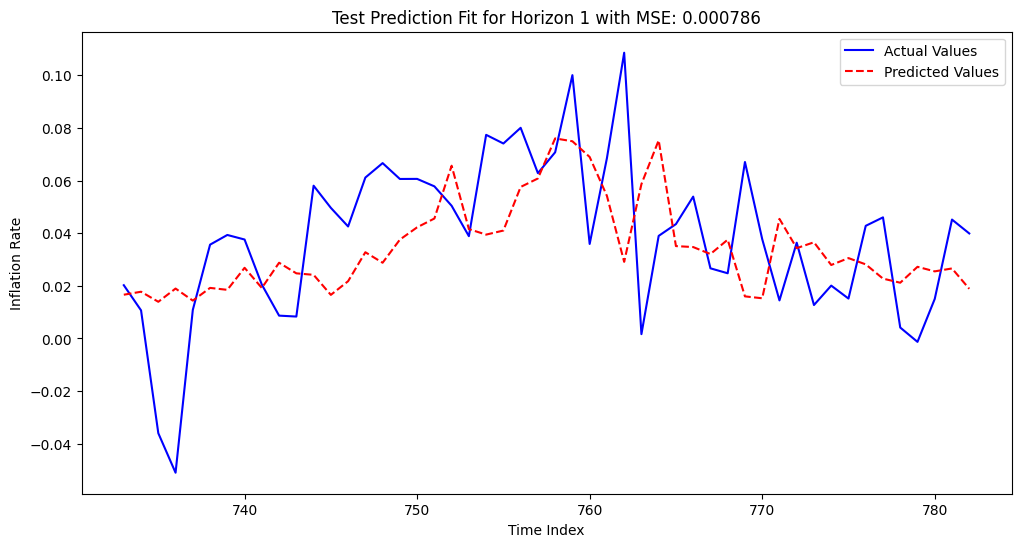

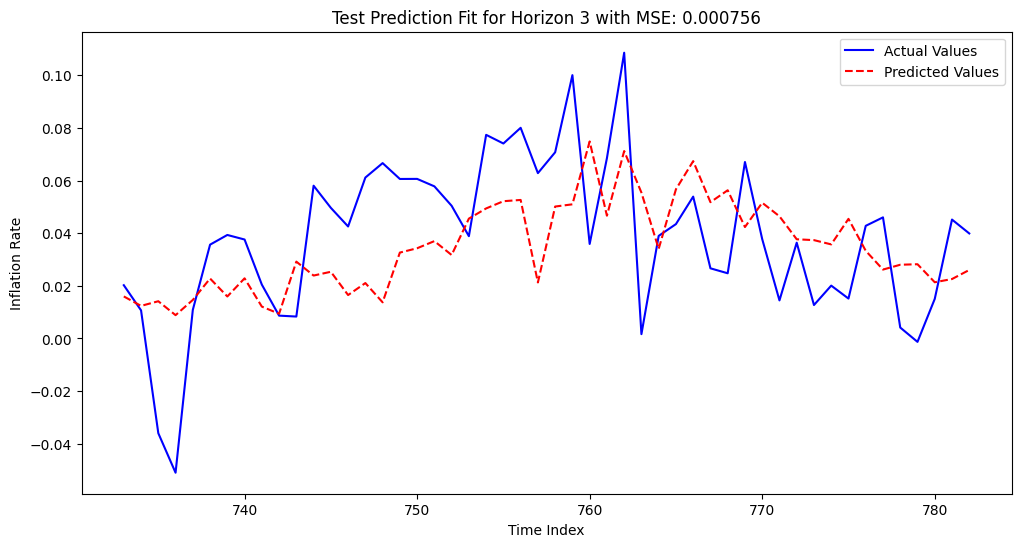

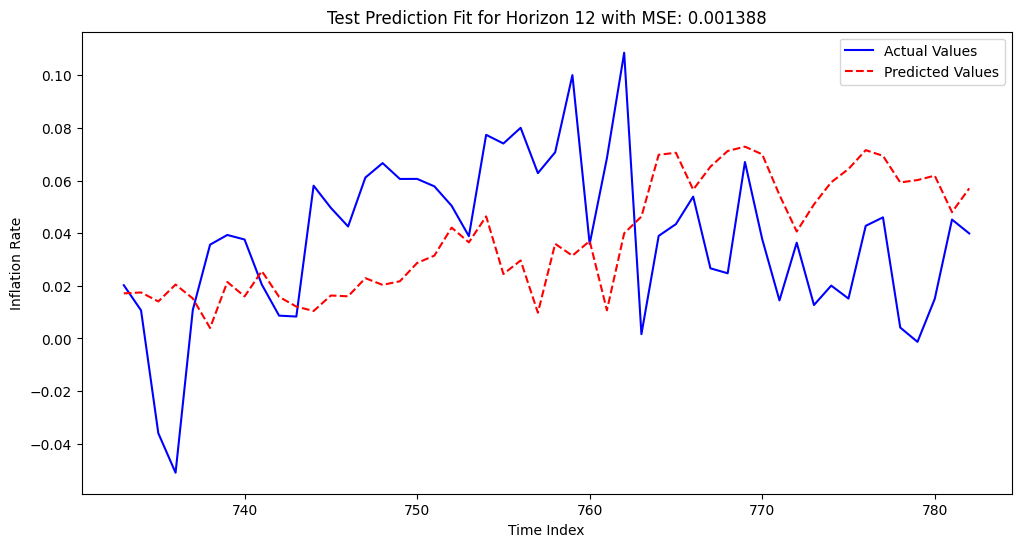

In [22]:
mse_random_forest = {}
for horizon in horizons:
    X_test, y_test = prepare_test_data(train_predictors, train_inflation_rate, test_predictors, test_inflation_rate, n_lags, horizon)
    model_random_forest = models_random_forest[horizon]  # Retrieve the model trained for this specific horizon
    
    y_pred_test = model_random_forest.predict(X_test)
    mse_random_forest[horizon] = mean_squared_error(y_test, y_pred_test)

    end_idx = len(combined_inflation_rate)  
    start_idx = end_idx - 50  

    plt.figure(figsize=(12, 6))
    plt.plot(combined_inflation_rate.index[start_idx:end_idx], y_test, label='Actual Values', color='blue')
    plt.plot(combined_inflation_rate.index[start_idx:end_idx], y_pred_test, label='Predicted Values', linestyle='--', color='red')
    plt.title(f"Test Prediction Fit for Horizon {horizon} with MSE: {mse_random_forest[horizon]:.6f}")
    plt.xlabel('Time Index')
    plt.ylabel('Inflation Rate')
    plt.legend()
    plt.show()

### 2.5 Gradient Boosting

#### 2.5.1 Model Training and In-Sample Fitting

While Gradient Boosting shares similarities with Random Forest in being an ensemble learning method, it constructs models sequentially, with each new model attempting to correct the errors made by the previous ones. The code below outlines the similar steps for model training and validation. Here, the parameter learning_rate controls the step size at each iteration while moving towards a minimum of the loss function. The max_depth still indicates the maximum depth of the trees. We set early stopping rounds to halt the iterative training process prematurely, in order to prevent overfitting.

Training XGBoost model for 1-month ahead prediction:
Training with params: {'learning_rate': 0.01, 'max_depth': 3}
Average MSE for current params: 0.0009
Training with params: {'learning_rate': 0.01, 'max_depth': 5}
Average MSE for current params: 0.0010
Training with params: {'learning_rate': 0.1, 'max_depth': 3}
Average MSE for current params: 0.0008
Training with params: {'learning_rate': 0.1, 'max_depth': 5}
Average MSE for current params: 0.0009
Best parameters found: {'learning_rate': 0.1, 'max_depth': 3} with MSE: 0.0008


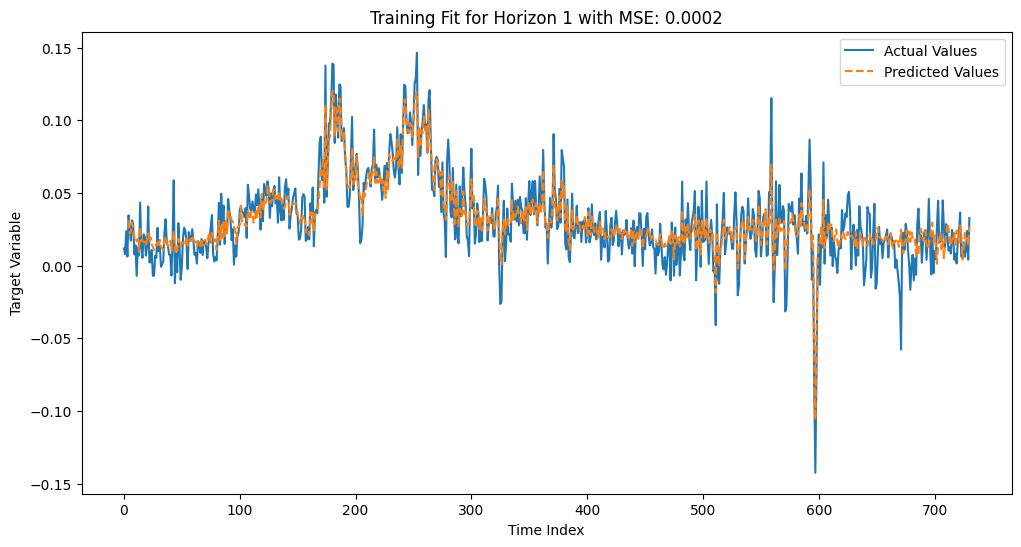

Horizon 1: Best MSE on Cross-Validation: 0.0008, Best Params: {'learning_rate': 0.1, 'max_depth': 3}
Horizon 1: Training Set MSE: 0.0002
Training XGBoost model for 3-month ahead prediction:
Training with params: {'learning_rate': 0.01, 'max_depth': 3}
Average MSE for current params: 0.0009
Training with params: {'learning_rate': 0.01, 'max_depth': 5}
Average MSE for current params: 0.0009
Training with params: {'learning_rate': 0.1, 'max_depth': 3}
Average MSE for current params: 0.0008
Training with params: {'learning_rate': 0.1, 'max_depth': 5}
Average MSE for current params: 0.0008
Best parameters found: {'learning_rate': 0.1, 'max_depth': 5} with MSE: 0.0008


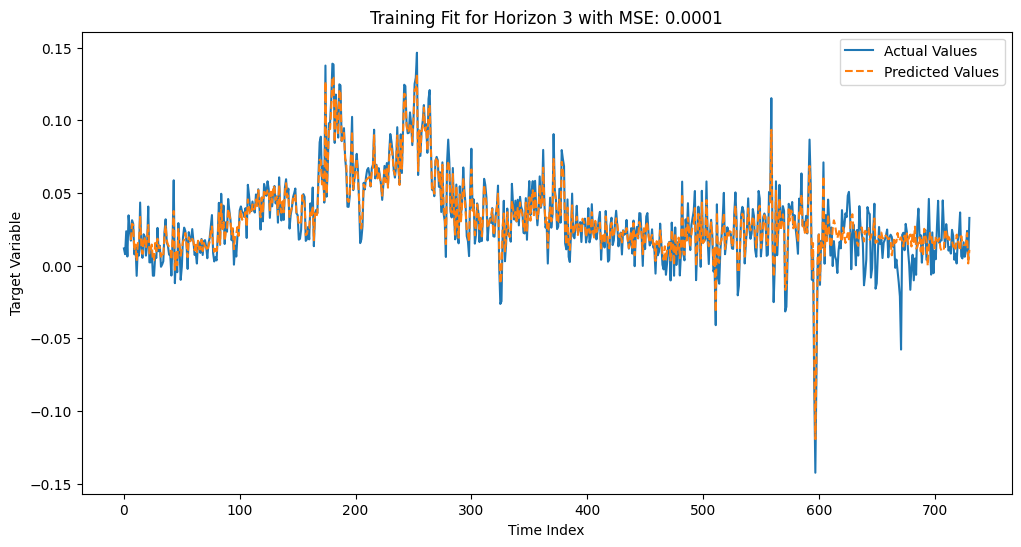

Horizon 3: Best MSE on Cross-Validation: 0.0008, Best Params: {'learning_rate': 0.1, 'max_depth': 5}
Horizon 3: Training Set MSE: 0.0001
Training XGBoost model for 12-month ahead prediction:
Training with params: {'learning_rate': 0.01, 'max_depth': 3}
Average MSE for current params: 0.0010
Training with params: {'learning_rate': 0.01, 'max_depth': 5}
Average MSE for current params: 0.0010
Training with params: {'learning_rate': 0.1, 'max_depth': 3}
Average MSE for current params: 0.0009
Training with params: {'learning_rate': 0.1, 'max_depth': 5}
Average MSE for current params: 0.0010
Best parameters found: {'learning_rate': 0.1, 'max_depth': 3} with MSE: 0.0009


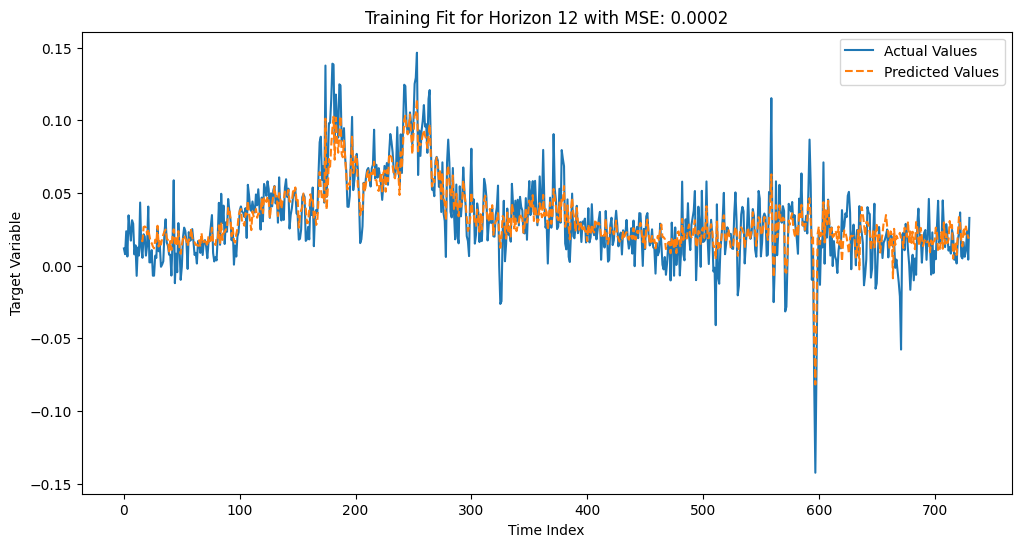

Horizon 12: Best MSE on Cross-Validation: 0.0009, Best Params: {'learning_rate': 0.1, 'max_depth': 3}
Horizon 12: Training Set MSE: 0.0002


In [12]:
import xgboost as xgb

def train_xgboost(X, y, n_splits, param_grid):
    # Initialize Time Series cross-validator
    tscv = TimeSeriesSplit(n_splits=n_splits)
    best_model = None
    best_mse = float('inf')
    best_params = None

    for params in ParameterGrid(param_grid):
        print(f"Training with params: {params}")
        # Initialize XGBoost regressor with parameters from the grid
        model_gradient_boosting = xgb.XGBRegressor(
            n_estimators=100,  
            learning_rate=params['learning_rate'],
            max_depth=params['max_depth'],
            random_state=42,
            n_jobs=-1,
            eval_metric="rmse",
            early_stopping_rounds=10  # Set early stopping rounds in the constructor
        )
        mse_list = []

        # Perform cross-validation
        for train_idx, test_idx in tscv.split(X):
            X_train, y_train = X[train_idx], y[train_idx]
            X_val, y_val = X[test_idx], y[test_idx]
            eval_set = [(X_val, y_val)]

            model_gradient_boosting.fit(X_train, y_train, eval_set=eval_set, verbose=False)
            y_pred = model_gradient_boosting.predict(X_val)
            # Calculate MSE for the current fold
            mse = mean_squared_error(y_val, y_pred)
            mse_list.append(mse)

        # Calculate the average MSE across all folds
        avg_mse = np.mean(mse_list)
        if avg_mse < best_mse:
            best_mse = avg_mse
            best_model = model_gradient_boosting
            best_params = params

        print(f"Average MSE for current params: {avg_mse:.4f}")

    print(f"Best parameters found: {best_params} with MSE: {best_mse:.4f}")
    return best_model, best_mse, best_params

# Define parameter grid to search over
param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}
n_splits = 5
n_lags = 3
horizons = [1, 3, 12]

models_gradient_boosting = {}
mse_scores = {}
best_params = {}

# Iterate over each forecasting horizon
for horizon in horizons:
    print(f"Training XGBoost model for {horizon}-month ahead prediction:")
    # Prepare data using the specified number of lags and the current horizon
    X, y = prepare_data(train_predictors_scaled, train_inflation_rate, n_lags, horizon)
    # Train the model using XGBoost with time series cross-validation
    model_gradient_boosting, mse, params = train_xgboost(X, y, n_splits, param_grid)
    # Store the best model, MSE and parameters for each horizon
    models_gradient_boosting[horizon] = model_gradient_boosting
    mse_scores[horizon] = mse
    best_params[horizon] = params
    
    # Predict on the training set using the best model to calculate in-sample MSE
    y_train_pred = model_gradient_boosting.predict(X)
    train_mse = mean_squared_error(y, y_train_pred)

    # Visualize the fit on the training set
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(train_inflation_rate)), train_inflation_rate, label='Actual Values')
    pred_start = n_lags + horizon
    plt.plot(range(pred_start, pred_start + len(y_train_pred)), y_train_pred, label='Predicted Values', linestyle='--')
    plt.title(f"Training Fit for Horizon {horizon} with MSE: {train_mse:.4f}")
    plt.xlabel('Time Index')
    plt.ylabel('Target Variable')
    plt.legend()
    plt.show()

    # Print results for this horizon
    print(f"Horizon {horizon}: Best MSE on Cross-Validation: {mse:.4f}, Best Params: {params}")
    print(f"Horizon {horizon}: Training Set MSE: {train_mse:.4f}")

#### 2.5.2 Out-of-Sample Prediction

The following plots illustrate the comparison between the actual and predicted inflation rates for the 1-month, 3-month, and 12-month horizons. Unfortunately, the out-of-sample predictions appear relatively flat, indicating that the models struggled to capture the variability in the inflation rate over the test period. The possible reasons could be various. While the models performed reasonable in-sample, they may have overfitted the training data, which could result in poor generalization to new data. Secondly, in order to save computational resources, the hyperparameter tuning was limited, thus the chosen parameters may not have been optimal for capturing the dynamic nature of the inflation rate in the test set.

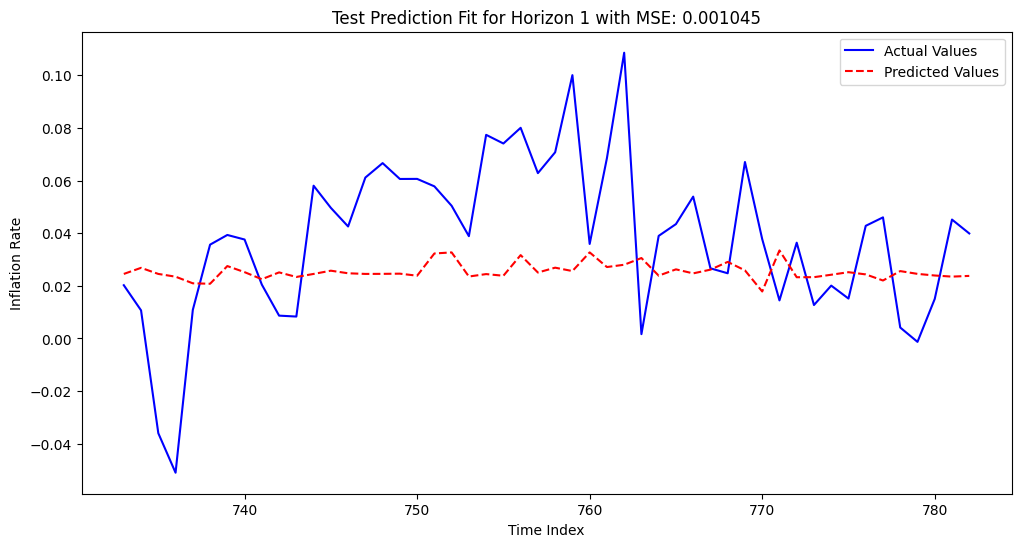

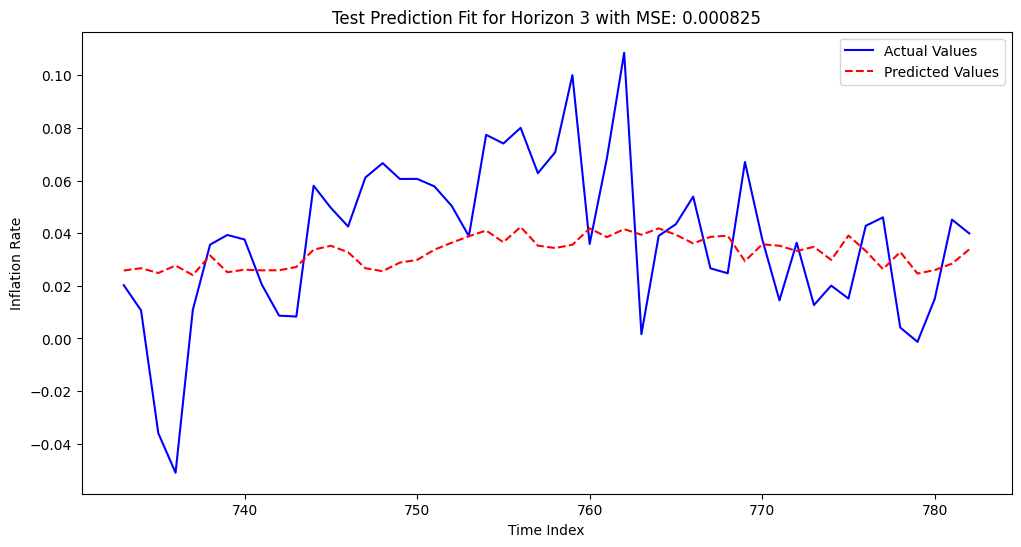

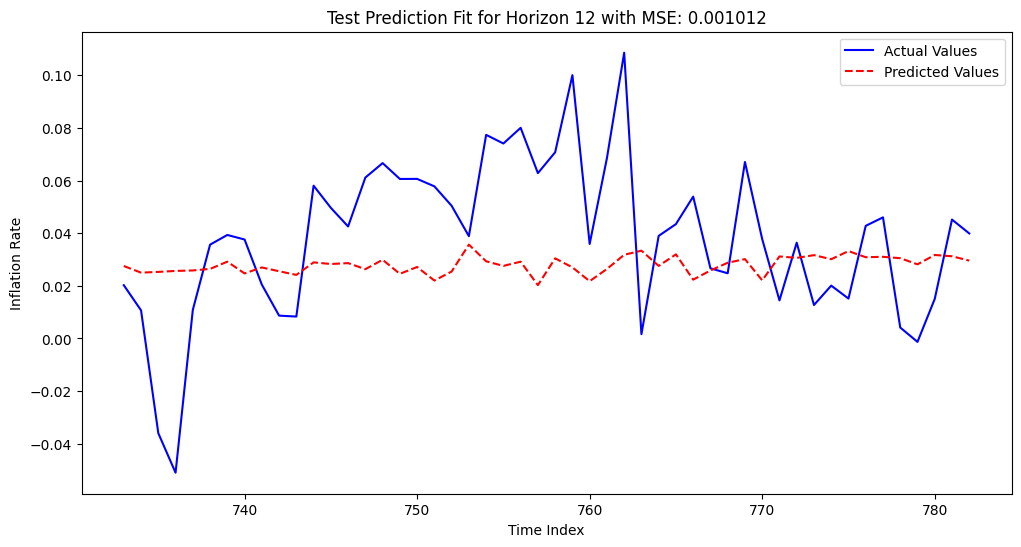

In [13]:
mse_gradient_boosting = {}
for horizon in horizons:
    X_test, y_test = prepare_test_data(train_predictors, train_inflation_rate, test_predictors, test_inflation_rate, n_lags, horizon)
    model_gradient_boosting = models_gradient_boosting[horizon]  # Retrieve the model trained for this specific horizon
    
    y_pred_test = model_gradient_boosting.predict(X_test)
    mse_gradient_boosting[horizon] = mean_squared_error(y_test, y_pred_test)

    end_idx = len(combined_inflation_rate)  
    start_idx = end_idx - 50  

    plt.figure(figsize=(12, 6))
    plt.plot(combined_inflation_rate.index[start_idx:end_idx], y_test, label='Actual Values', color='blue')
    plt.plot(combined_inflation_rate.index[start_idx:end_idx], y_pred_test, label='Predicted Values', linestyle='--', color='red')
    plt.title(f"Test Prediction Fit for Horizon {horizon} with MSE: {mse_gradient_boosting[horizon]:.6f}")
    plt.xlabel('Time Index')
    plt.ylabel('Inflation Rate')
    plt.legend()
    plt.show()

## 3 Evaluation Summary and Conclusion

In this section, we summarize the performance of the different forecasting models in this study. The models, as required, are assessed based on their out-of-sample MSE. The summary table below presents the MSE values for each model, followed by a visualization illustrating the performance of each forecasting model for the 1-month, 3-month, and 12-month horizons. To sum up, for the 1-month-ahead forecast, the LASSO model performs the best with a MSE of 0.000636. For the 3-month-ahead forecast, the Random Forest model shows the lowest MSE of 0.000756. For the 12-month-ahead forecast, the SVR model performs best with an MSE of 0.000896.

,1-Month,3-Month,12-Month
Method,,,
AR(1) (Direct),0.000676,0.000798,0.001124
AR(1) (Recursive),0.000676,0.000783,0.000940
LASSO,0.000636,0.000947,0.001027
SVR,0.000735,0.000785,0.000896
Random Forest,0.000786,0.000756,0.001388
Gradient Boosting,0.001045,0.000825,0.001012


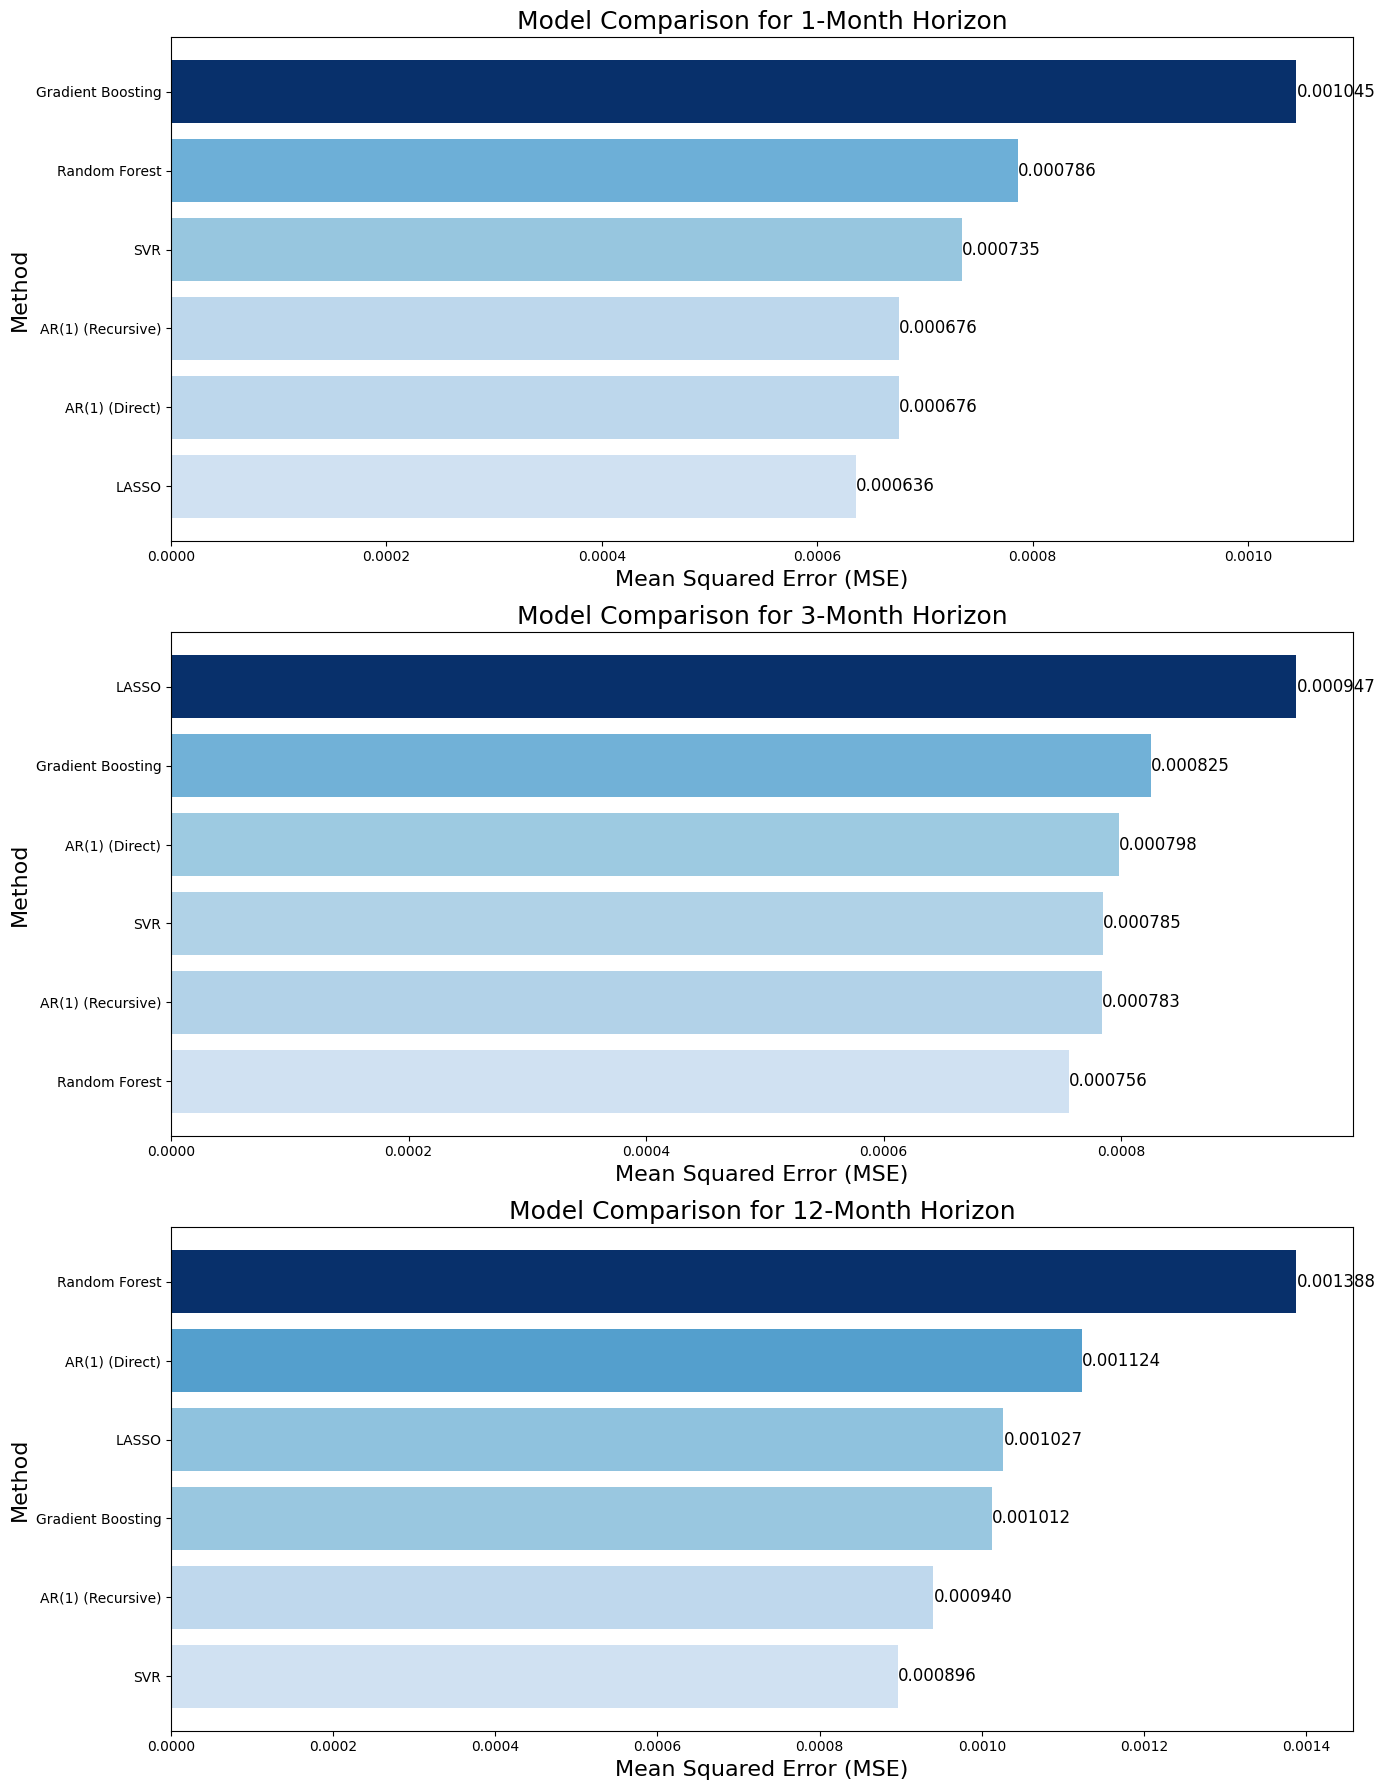

In [45]:
import matplotlib.pyplot as plt

# Create a DataFrame to summarize the out-of-sample MSE values
mse_summary = pd.DataFrame({
    'Method': ['AR(1) (Direct)', 'AR(1) (Recursive)', 'LASSO', 'SVR', 'Random Forest', 'Gradient Boosting'],
    '1-Month': [mse_ar1_direct[1], mse_ar1_recursive[1], mse_lasso[1], mse_svr[1], mse_random_forest[1], mse_gradient_boosting[1]],
    '3-Month': [mse_ar1_direct[3], mse_ar1_recursive[3], mse_lasso[3], mse_svr[3], mse_random_forest[3], mse_gradient_boosting[3]],
    '12-Month': [mse_ar1_direct[12], mse_ar1_recursive[12], mse_lasso[12], mse_svr[12], mse_random_forest[12], mse_gradient_boosting[12]]
})

# Set the 'Method' column as the index
mse_summary.set_index('Method', inplace=True)

# Display the DataFrame
display(mse_summary)

# Define a function to plot bar charts for MSE with gradient color
def plot_mse_bar_chart(mse_summary):
    methods = mse_summary.index
    horizons = mse_summary.columns

    # Create a subplot with 3 rows and 1 column
    fig, axes = plt.subplots(3, 1, figsize=(14, 18))

    for idx, horizon in enumerate(horizons):
        mse_values = mse_summary[horizon]
        sorted_indices = np.argsort(mse_values)
        sorted_methods = methods[sorted_indices]
        sorted_mse_values = mse_values.iloc[sorted_indices]

        # Normalize the MSE values for the gradient
        norm = plt.Normalize(sorted_mse_values.min(), sorted_mse_values.max())
        colors = plt.cm.Blues(norm(sorted_mse_values * 0.8 + sorted_mse_values.max() * 0.2))  # Adjust colors to be darker

        # Plot horizontal bar chart with gradient color
        bars = axes[idx].barh(sorted_methods, sorted_mse_values, color=colors)

        # Add text labels to the bars
        for i, v in enumerate(sorted_mse_values):
            axes[idx].text(v, i, f'{v:.6f}', va='center', ha='left', size=12)

        axes[idx].set_xlabel('Mean Squared Error (MSE)', size=16)
        axes[idx].set_ylabel('Method', size=16)
        axes[idx].set_title(f'Model Comparison for {horizon} Horizon', size=18)

    plt.tight_layout()
    plt.show()

# Plot bar charts for each horizon
plot_mse_bar_chart(mse_summary)

The methods taken and the models evaluated in this study are not without limitations. For several approaches mentioned, more extensive hyperparameter tuning using more sophisticated techniques could be performed to find the optimal set of parameters. Other advanced machine learning techniques and exsemble learning methods that combine multiple models may be implemented to improve forecast accuracy and robustness. Additionally, other macroeconomic indicators and predictor selection methods could be incorporated to enhance the predictive power of all the models.